In [ ]:
# Установка библиотек
!pip install ultralytics adversarial-robustness-toolbox torch torchvision matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.4/910.4 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.7 MB/s eta 0:00:00


In [ ]:
# Импорт библиотек
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import DataLoader

# Преобразования изображений
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Нормализация
])

# Загрузка данных
train_data = SVHN(root='./data', split='train', download=True, transform=transform)
test_data = SVHN(root='./data', split='test', download=True, transform=transform)

# Даталоадеры
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


100%|██████████| 182M/182M [00:30<00:00, 5.88MB/s]


100%|██████████| 64.3M/64.3M [00:12<00:00, 5.00MB/s]


In [ ]:
# Импорт необходимых библиотек
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np

# Загрузка предобученной модели ResNet18
base_model = resnet18(pretrained=True)

# Адаптация для набора данных SVHN (10 классов)
base_model.fc = Linear(base_model.fc.in_features, 10)

# Отправка на устройство (GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = base_model.to(device)

In [ ]:
from art.estimators.classification import PyTorchClassifier
from torch.optim import Adam
import torch.nn as nn

# Определение классификатора
criterion = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters(), lr=0.001)

classifier = PyTorchClassifier(
    model=base_model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)


In [ ]:
# Обучение модели
def train_model(classifier, train_loader, epochs=1):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        for images, labels in train_loader:
            # Перемещение данных на устройство (CPU или GPU)
            images, labels = images.to(device), labels.to(device)

            # Перевод модели в режим обучения
            classifier.model.train()

            # Обнуление градиентов
            classifier.optimizer.zero_grad()

            # Прямой проход
            outputs = classifier.model(images)

            # Вычисление ошибки
            loss = classifier.loss(outputs, labels)

            # Обратное распространение ошибки
            loss.backward()

            # Шаг оптимизации
            classifier.optimizer.step()

        print(f"Loss: {loss.item():.4f}")


In [ ]:
# Генерация adversarial examples
def generate_adversarial_examples(attack, data_loader):
    adv_examples = []
    original_images = []
    for images, labels in data_loader:
        # Перемещение данных на CPU, так как ART работает с numpy
        images = images.cpu().numpy()

        # Генерация adversarial examples
        adv_images = attack.generate(x=images)

        adv_examples.append(adv_images)
        original_images.append(images)
        break  # Для демонстрации берем 1 батч
    return adv_examples, original_images


In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

# Инициализация PyTorchClassifier
classifier = PyTorchClassifier(
    model=base_model,  # Ваша модель
    clip_values=(0, 1),  # Нормализация входных данных
    loss=torch.nn.CrossEntropyLoss(),  # Функция потерь
    optimizer=torch.optim.Adam(base_model.parameters(), lr=0.001),  # Оптимизатор
    input_shape=(3, 32, 32),  # Размер входных данных
    nb_classes=10,  # Количество классов
)

# Настройка атаки FGSM
attack = FastGradientMethod(estimator=classifier, eps=0.1)


In [ ]:
adv_examples, original_images = generate_adversarial_examples(attack, test_loader) # проверка выхова функции


In [ ]:
print(f"Adversarial examples: {len(adv_examples)}")
print(f"Original images: {len(original_images)}") #проверка все ли работает правильно, не пустые ли массивы


Adversarial examples: 1
Original images: 1


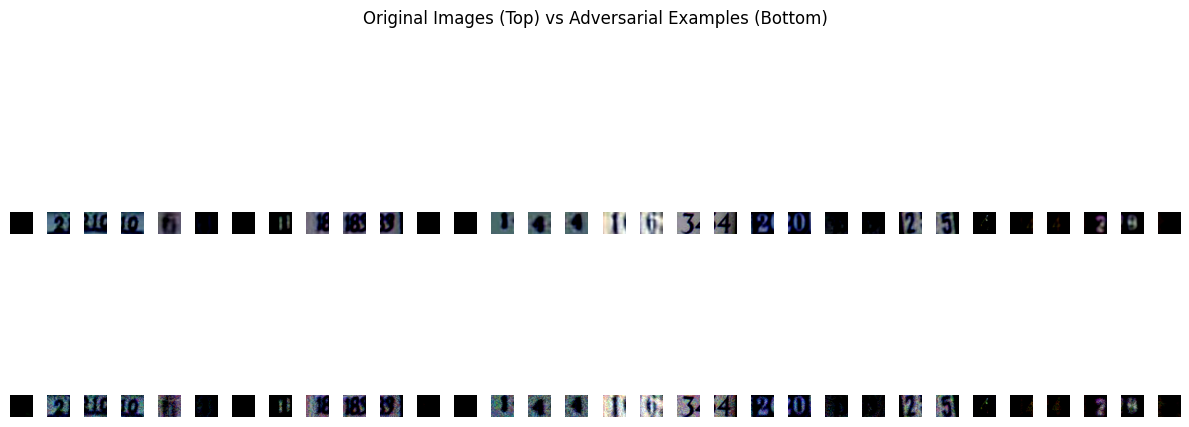

In [ ]:
import matplotlib.pyplot as plt

def visualize_examples(original, adversarial, labels=None):
    """
    Функция для визуализации оригинальных и adversarial изображений.

    :param original: Массив оригинальных изображений (numpy array)
    :param adversarial: Массив adversarial изображений (numpy array)
    :param labels: Метки классов (optional)
    """
    fig, axes = plt.subplots(2, len(original), figsize=(12, 6))
    fig.suptitle("Original Images (Top) vs Adversarial Examples (Bottom)")

    for i in range(len(original)):
        # Оригинальные изображения
        axes[0, i].imshow(original[i].transpose(1, 2, 0))  # Для преобразования формата (C, H, W) -> (H, W, C)
        axes[0, i].axis('off')
        if labels is not None:
            axes[0, i].set_title(f"Label: {labels[i]}")

        # Adversarial изображения
        axes[1, i].imshow(adversarial[i].transpose(1, 2, 0))
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Вызов функции визуализации
visualize_examples(original_images[0], adv_examples[0])



Цель визуализации — показать разницу между оригинальными изображениями и их adversarial версиями. Даже если изменения незаметны для человеческого глаза, они могут быть критичны для модели

In [ ]:
# Предсказания для оригинальных изображений
original_predictions = np.argmax(classifier.predict(original_images[0]), axis=1)

# Предсказания для adversarial изображений
adversarial_predictions = np.argmax(classifier.predict(adv_examples[0]), axis=1)

# Печать результатов
for i in range(len(original_predictions)):
    print(f"Image {i+1}: Original -> {original_predictions[i]}, Adversarial -> {adversarial_predictions[i]}")


Image 1: Original -> 2, Adversarial -> 2
Image 2: Original -> 2, Adversarial -> 8
Image 3: Original -> 0, Adversarial -> 8
Image 4: Original -> 2, Adversarial -> 3
Image 5: Original -> 2, Adversarial -> 8
Image 6: Original -> 0, Adversarial -> 0
Image 7: Original -> 0, Adversarial -> 0
Image 8: Original -> 7, Adversarial -> 5
Image 9: Original -> 2, Adversarial -> 8
Image 10: Original -> 2, Adversarial -> 5
Image 11: Original -> 5, Adversarial -> 8
Image 12: Original -> 0, Adversarial -> 0
Image 13: Original -> 2, Adversarial -> 2
Image 14: Original -> 0, Adversarial -> 8
Image 15: Original -> 2, Adversarial -> 8
Image 16: Original -> 2, Adversarial -> 8
Image 17: Original -> 5, Adversarial -> 8
Image 18: Original -> 0, Adversarial -> 8
Image 19: Original -> 5, Adversarial -> 8
Image 20: Original -> 5, Adversarial -> 8
Image 21: Original -> 2, Adversarial -> 3
Image 22: Original -> 2, Adversarial -> 8
Image 23: Original -> 2, Adversarial -> 8
Image 24: Original -> 2, Adversarial -> 5
I

Тут видно, как изменились предсказания модели из-за adversarial примеров. Так как изменения заметны, то атака считается успешной.